In [1]:
import pandas as pd
%matplotlib inline
import statsmodels
import statsmodels.api as sm
from statsmodels.formula.api import ols
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.stattools import durbin_watson
from scipy import stats
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
from numpy import median
# from tqdm.auto import tqdm

plt.style.use('ggplot')

### Выгружаем данные по экспрессии белков

In [2]:
NPX_values = pd.read_excel('Olink Filbin sep2.xlsx', sheet_name='NPX-values', engine='openpyxl')
proteins_olink_id = NPX_values.columns[3:].tolist()
NPX_values.head()

Patient ID TimePoint Public ID  OID20321  OID20206  OID20195  OID20094  \
0           1        D0      1_D0    4.1968    5.5310    1.9006    1.8485   
1           1        D3      1_D3    4.4069    4.8519    1.9494    2.5663   
2           2        D0      2_D0    4.2154    7.7046    3.0798    1.7002   
3           2        D3      2_D3    3.6566    4.0996    3.1320    1.5452   
4           3        D0      3_D0    4.5419    6.5252    3.0772    2.6232   

   OID20216  OID20106  OID20324  ...  OID21321  OID21392  OID21431  OID21526  \
0    1.7707    1.2732    6.1899  ...    1.1620    1.0855    3.0789    4.9206   
1    2.8049    2.0977    6.1705  ...    0.8499    2.5745    3.2516    5.0204   
2    3.4876    1.4211    6.0646  ...    0.1613    2.0945    3.9362    4.9951   
3    3.0139    1.1949    6.0163  ...    0.2679    2.1206    3.3563    4.8884   
4    2.0130    1.9144    6.9371  ...    1.1938    1.6921    5.2543    5.0991   

   OID21450  OID21518  OID21221  OID21261  OID21170  OID21469  
0    2.4184    0.2835    0.2565    1.3113    0.3989    6.0460  
1    4.4798    0.8444   -0.1346    1.1760    0.2140    6.1251  
2    5.1464    0.5832   -0.1294    1.3470    2.0584    6.2058  
3    5.3548    0.5351    0.1101    1.1459    0.6812    6.1157  
4    3.2783    0.6823   -0.0734    2.2012    0.7255    8.3616  

[5 rows x 1432 columns]

### Выгружаем клинические данные

In [3]:
clinical_data = pd.read_excel('1-s2.0-S2666379121001154-mmc2 (1).xlsx', sheet_name = '1B-Subject-level metadata')
clinical_data.head()

Public ID  COVID  Age cat  BMI cat  HEART  LUNG  KIDNEY  DIABETES  HTN  \
0          1      1        1        4      0     0       0         0    0   
1          2      1        2        2      0     0       0         0    0   
2          3      1        3        4      0     1       0         0    0   
3          4      1        1        2      0     0       0         0    0   
4          5      1        3        3      0     0       0         1    1   

   IMMUNO  ...  crp_3_cat  ddimer_3_cat  ldh_3_cat  abs_neut_7_cat  \
0       0  ...        1.0           1.0        1.0             NaN   
1       0  ...        2.0           NaN        NaN             NaN   
2       0  ...        3.0           2.0        3.0             NaN   
3       0  ...        2.0           2.0        3.0             NaN   
4       0  ...        5.0           3.0        NaN             3.0   

   abs_lymph_7_cat  abs_mono_7_cat  creat_7_cat  crp_7_cat  ddimer_7_cat  \
0              NaN             NaN          NaN        NaN           NaN   
1              NaN             NaN          NaN        NaN           NaN   
2              NaN             NaN          NaN        NaN           NaN   
3              NaN             NaN          NaN        NaN           NaN   
4              5.0             3.0          1.0        4.0           4.0   

   ldh_7_cat  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        3.0  

[5 rows x 44 columns]

### Выгружаем информацию о названиях и id белков

In [4]:
protein_metadata = pd.read_excel('Olink Filbin sep2.xlsx', sheet_name='Olink-Assay', engine='openpyxl').set_index('OlinkID')
protein_metadata.head()

Assay UniProt  MissingFreq     LOD            Panel  Panel_Version
OlinkID                                                                      
OID20049    NPPB  P16860         0.55  1.9691  CARDIOMETABOLIC              1
OID20050   TNNI3  P19429         0.76  1.7430  CARDIOMETABOLIC              1
OID20051  HNRNPK  P61978         0.76  1.0000  CARDIOMETABOLIC              1
OID20052   CEBPB  P17676         0.80  0.6993  CARDIOMETABOLIC              1
OID20053     VIM  P08670         0.86  1.9438  CARDIOMETABOLIC              1

### Строим линейную модель вида для данных на день 0:
### NPX ~ covid_status + age_category + heart_disease + lung_disease + kidney_disease + diabetes + HTN + immuno_disease

In [5]:
def ANOVA_analysis_d0(data, proteins, covariates):
    ss_proteins = []
    for protein in proteins:
        subset = data[~pd.isna(data[protein])] 
        model = ols(protein + '~' + '+'.join(covariates), data = subset).fit()
        if model.f_pvalue < 0.05:
            #берем все строки, кроме последней (Residuals)
            aov_table = sm.stats.anova_lm(model).iloc[:-1]
            aov_table['Adjusted_pval'] = statsmodels.stats.multitest.fdrcorrection(aov_table.loc[:, 'PR(>F)'].values)[1]
            if (aov_table.loc['COVID', 'PR(>F)'] < 0.05) & (aov_table.loc['COVID', 'Adjusted_pval'] < 0.05):
                ss_proteins.append(protein)
    return ss_proteins

In [6]:
covariates_d0 = ['COVID', 'Age_cat', 'HEART', 'LUNG', 'KIDNEY', 'DIABETES', 'HTN', 'IMMUNO']
NPX_clinical_data = NPX_values.merge(clinical_data.rename(columns = {'Public ID' : 'Patient ID', 
                    'Age cat' : 'Age_cat'}).loc[:, ['Patient ID'] + covariates_d0],
                    how = 'inner', on = ['Patient ID'])
NPX_clinical_data_d0 = NPX_clinical_data[NPX_clinical_data['TimePoint'] == 'D0']
ss_proteins = ANOVA_analysis_d0(NPX_clinical_data_d0, proteins_olink_id, covariates_d0)

In [7]:
NPX_clinical_data_d0.head()

Patient ID TimePoint Public ID  OID20321  OID20206  OID20195  OID20094  \
0           1        D0      1_D0    4.1968    5.5310    1.9006    1.8485   
2           2        D0      2_D0    4.2154    7.7046    3.0798    1.7002   
4           3        D0      3_D0    4.5419    6.5252    3.0772    2.6232   
6           4        D0      4_D0    4.1950    3.1439    4.5754    2.2037   
8           5        D0      5_D0    4.1539    3.8130    3.9621    2.9070   

   OID20216  OID20106  OID20324  ...  OID21170  OID21469  COVID  Age_cat  \
0    1.7707    1.2732    6.1899  ...    0.3989    6.0460      1        1   
2    3.4876    1.4211    6.0646  ...    2.0584    6.2058      1        2   
4    2.0130    1.9144    6.9371  ...    0.7255    8.3616      1        3   
6    2.7681    1.7843    3.2874  ...    0.2458    4.9287      1        1   
8    4.3405    2.1376    6.0795  ...    0.8075    5.2392      1        3   

   HEART  LUNG  KIDNEY  DIABETES  HTN  IMMUNO  
0      0     0       0         0    0       0  
2      0     0       0         0    0       0  
4      0     1       0         0    0       0  
6      0     0       0         0    0       0  
8      0     0       0         1    1       0  

[5 rows x 1440 columns]

### Проверяем наличие статистических различий в количестве белка у больной и здоровой когорты на день 0.

In [8]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
#     for i in tqdm(range(boot_it)): # извлекаем подвыборки
    for i in range(boot_it):
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    return p_value

In [9]:
def statistical_test_for_two_cohorts(proteins, data):
    results = pd.DataFrame()
    for protein in proteins:
        subset = data[~pd.isna(data[protein])]
        covid_p = subset[subset['COVID'] == 1].loc[:, protein]
        covid_n = subset[subset['COVID'] == 0].loc[:, protein]
        p_value = get_bootstrap(covid_p, covid_n)
        results = results.append([[protein, p_value]],
                                ignore_index = True)
    results.columns = ['protein', 'pvalue']
    results['Adjusted_pvalue'] = statsmodels.stats.multitest.fdrcorrection(results['pvalue'].values)[1]
    results['Fold_change'] = results.apply(lambda x: data[(data['COVID'] == 1)].loc[:, x.protein].mean() - data[(data['COVID'] == 0)].loc[:, x.protein].mean(), axis = 1)
    return results

In [ ]:
results = statistical_test_for_two_cohorts(proteins_olink_id, NPX_clinical_data_d0)

In [ ]:
results.head()

In [ ]:
def volcano_plot(results, ss_proteins, protein_metadata, threshold_fc, threshold_pvalue, path_fig = None):
    results_red = results[(results['Fold_change'].abs() > threshold_fc) & (
        results['Adjusted_pvalue'] < threshold_pvalue) & (results['pvalue'] < threshold_pvalue
                                                         ) & (results['protein'].isin(ss_proteins))]
    results_red.loc[:, 'Assay'] = protein_metadata.loc[results_red.protein.values, 'Assay'].values
    results_green = results[(results['protein'].isin(ss_proteins)) & (results['Adjusted_pvalue'] < threshold_pvalue
                                                                     ) & (results['pvalue'] < threshold_pvalue
                                                         )& (~results.index.isin(results_red.index))]
    results_grey = results[~results.index.isin(results_red.index.tolist() + results_green.index.tolist())]
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.scatter(results_red.Fold_change, -np.log10(results_red.Adjusted_pvalue), c = 'red',
              label = 'validated by ANOVA \n& statistical comparison \nof cohorts & thresholds')
    ax.scatter(results_green.Fold_change, -np.log10(results_green.Adjusted_pvalue), c = 'green',
              label = 'validated by ANOVA \n& statistical comparison \nof cohorts')
    ax.scatter(results_grey.Fold_change, -np.log10(results_grey.Adjusted_pvalue), c = 'grey',
              label = 'non-validated by ANOVA \nand/or statistical \ncomparison of cohorts')
    style = dict(size = 12, color = 'black')
#     results_red[-np.log10(results_red.Adjusted_pvalue) > 60].apply(lambda x: ax.annotate(x.Assay, (x.Fold_change, -np.log10(x.Adjusted_pvalue)), **style), axis = 1)
    results_red.apply(lambda x: ax.annotate(x.Assay, (x.Fold_change, -np.log10(x.Adjusted_pvalue)), **style), axis = 1)
    ax.axvline(x = threshold_fc, c = 'blue', linestyle = '--', label = 'thresholds')
    ax.axvline(x = -threshold_fc, c = 'blue', linestyle = '--' )
    ax.axhline(y = -np.log10(threshold_pvalue), c = 'blue', linestyle = '--')
    ax.text(results.Fold_change.max(), -np.log10(threshold_pvalue), 'pvalue = {}'.format(threshold_pvalue), fontsize=14, va='bottom', ha='right')
    ax.set_xlabel('FoldChange', fontsize = 16, c = 'black')
    ax.set_ylabel('-log10(Adjusted p-value)', fontsize = 16, c = 'black')
    ax.legend(loc = 'upper left', fontsize = 10)
    plt.xticks(fontsize=16, c = 'black')
    plt.yticks(fontsize=16, c = 'black')
    fig.tight_layout()
    plt.show()
    if path_fig:
        fig.savefig(path_fig, dpi = 300)
    return results_red[['protein', 'Assay','Fold_change','pvalue','Adjusted_pvalue']].rename(columns = {'protein':'OlinkID'}).reset_index(drop = True)    

In [ ]:
final_result = volcano_plot(results, ss_proteins, protein_metadata, threshold_fc = 1, threshold_pvalue = 0.05)

In [ ]:
final_result[-np.log10(final_result.Adjusted_pvalue) > 60].reset_index(drop = True)

### Строим линейную модель для определения белков, демонстрирующих прогресс заболевания и тяжесть: NPX ~ timepoint + severity + (1|patient_id) + clinical_features + result + result:severity

In [ ]:
#подготовка данных к ANOVA
covariates = ['COVID', 'Age_cat', 'HEART', 'LUNG', 'KIDNEY', 'DIABETES', 'HTN', 'IMMUNO', 'severity', 'result']
NPX_clinical_data = NPX_values.merge(clinical_data.rename(columns = {'Public ID' : 'Patient ID', 'Age cat' : 'Age_cat',
                                             'Acuity 0': 'severity', 'Acuity 28':'result'}).loc[:, ['Patient ID'] + covariates], how = 'inner', on = ['Patient ID'])
NPX_clinical_data = NPX_clinical_data[NPX_clinical_data['TimePoint'].isin(['D0','D3','D7']) & (NPX_clinical_data['COVID'] == 1)
                                   & (NPX_clinical_data['severity'] !=1)]
#для обучения модели делим пациентов по тяжести на две группы: severe(A2,A3) - 1 & non-severe(A4,A5) - 1
severity_dict = {3:1, 2:1, 4:0, 5:0}
#для обучения модели делим пациентов по outcome на три группы: discharged - 1, in hospital - 2, dead - 3
result_dict = {5:1, 2:2, 3:2, 1:3, 4:2}
#для обучения переводим дни в числовые переменные
days_dict = {'D0': 1, 'D3' : 2, 'D7' : 3}
NPX_clinical_data = NPX_clinical_data.replace({'severity' : severity_dict, 'result' : result_dict,
                                            'TimePoint' : days_dict}).reset_index(drop = True)
NPX_clinical_data.head()

In [ ]:
def ANOVA_progress_severity(NPX_clinical_data, proteins_olink_id):
    progr_proteins = []
    for protein in proteins_olink_id:
        subset = NPX_clinical_data[~pd.isna(NPX_clinical_data[protein])]
        covariates_new = ['Age_cat', 'HEART', 'LUNG', 'KIDNEY', 'DIABETES', 'HTN', 'IMMUNO']
        model = ols(protein + '~' + '+'.join(covariates_new + ['TimePoint', 'severity', 
                                                '(1|patient_id)', 'result', 'result:severity']),
                   data = subset.rename(columns = {'Patient ID' : 'patient_id'})).fit()
        if model.f_pvalue < 0.05:
            aov_table = sm.stats.anova_lm(model).iloc[:-1]
            aov_table['Adjusted_pval'] = statsmodels.stats.multitest.fdrcorrection(aov_table.loc[:, 'PR(>F)'].values)[1]
            if ((aov_table.loc[['TimePoint', 'severity'], 'PR(>F)'] < 0.05).all()) & ((aov_table.loc[['TimePoint', 'severity'], 'Adjusted_pval'] < 0.05).all()):
                progr_proteins.append(protein)
    return progr_proteins

In [ ]:
progr_proteins = ANOVA_progress_severity(NPX_clinical_data, proteins_olink_id)

In [ ]:
#подготовка данных к парным стат тестам
category_severity_dict = {1:'severe', 0:'non-severe'}
inv_days_dict = {v: k for k, v in days_dict.items()}
NPX_clinical_data = NPX_clinical_data.replace({'severity' : category_severity_dict,
                                            'TimePoint' : inv_days_dict})
NPX_clinical_data['group'] = NPX_clinical_data['TimePoint'] + "_" + NPX_clinical_data['severity']
NPX_clinical_data.head()

In [ ]:
def pairwise_gameshowell_test(progr_proteins, NPX_clinical_data):
    pairwise_results = pd.DataFrame()
    for protein in progr_proteins:
        res = pg.pairwise_gameshowell(data=NPX_clinical_data, dv=protein,
                            between='group')
        res = res[res['pval'] < 0.05]
        res['DayA'] = res['A'].str.slice(start = 0, stop = 2)
        res['DayB'] = res['B'].str.slice(start = 0, stop = 2)
        res['severity_A'] = res['A'].str.slice(start = 3)
        res['severity_B'] = res['B'].str.slice(start = 3)
        res = res[(res['severity_A'] == res['severity_B']) | (res['DayA'] == res['DayB'])]
        res['OlinkID'] = protein
        res = res.loc[:, ['OlinkID', 'DayA','DayB','severity_A', 'severity_B', 'pval']].reset_index(drop = True)
        res['day_pair'] = res['DayA'] + "_" + res['DayB']
        pairwise_results = pairwise_results.append(res, ignore_index = True)
    return pairwise_results

In [ ]:
pairwise_results = pairwise_gameshowell_test(progr_proteins, NPX_clinical_data)

In [ ]:
#добавляем информацию о названиях белков
sorted_results = pairwise_results.set_index('OlinkID').loc[pairwise_results.groupby('OlinkID').size().sort_values(ascending=False).index.tolist()]
sorted_results = sorted_results.merge(protein_metadata.loc[:, 'Assay'], how = 'inner', on = ['OlinkID'])[['Assay'] + sorted_results.columns[:-1].tolist()]
#выделяем топ белков для построения box-plot-ов
top = sorted_results.groupby('OlinkID').size().sort_values(ascending=False).index[:4].tolist()

In [ ]:
def plot_box_plot(top, NPX_clinical_data, pairwise_results, protein_metadata, path_to_save = None):
    sns.set_theme(style = "ticks", palette = "pastel")
    n_cols = int(np.sqrt(len(top)))
    n_rows = int(np.ceil(len(top) / n_cols))
    fig, axs = plt.subplots(n_rows, n_cols, figsize = (10*n_cols, 8*n_rows))
    for i, protein in enumerate(top):
        row = i // n_cols
        col = i % n_cols
        ax = axs[row] if (n_cols == 1) else axs[row, col]
        protein_info = protein_metadata.loc[protein, ['Assay', 'UniProt']].values.tolist()
        protein_label = protein_info[0] + '\n(' + protein_info[1] + ')'
        sns.boxplot(x="TimePoint", y=protein,
                    hue="severity", palette=["m", "g"],
                    data=NPX_clinical_data, showfliers = False, ax = ax)
    #     sns.stripplot(x="TimePoint", y=protein,
    #                 hue="severity", split = True, jitter=True,
    #                 data=NPX_metadata_new, linewidth=1, palette=["m", "g"], edgecolor='gray', ax = ax)
        sns.stripplot(x="TimePoint", y=protein,
                    hue="severity", jitter=True,
                    data=NPX_clinical_data, linewidth=1, palette=["m", "g"], edgecolor='gray', ax = ax)
        sns.pointplot(x="TimePoint", y=protein,
                hue="severity", split = True, jitter=True, dodge = True,
                data=NPX_clinical_data,estimator=median, linewidth=1, palette=["m", "g"], 
                  plot_kws=dict(alpha=1), linestyles=["--", "--"], ci = 0, ax = ax)

        progress = {'D0_D3': [0, 1], 'D0_D7': [0, 2], 'D3_D7':[1, 2]}
        _y = []
        for comb, _x in progress.items():
            x1, x2 = _x
            y, h, col = NPX_clinical_data[(NPX_clinical_data['TimePoint'].isin(comb.split('_')))].loc[:,protein].max() + 0.5, 0.1, 'm'
            if _y:
                go = True
                for elem in _y:
                    if abs(y - elem) < 0.7:
                        go = False
                if go==False:
                    y = max(_y) + 0.7
            else:
                y = y + 0.5
            _y.append(y)        
            ax.plot([x1-0.2, x1-0.2, x2-0.2, x2-0.2], [y, y+h, y+h, y], lw=1.5, c=col)
            if pairwise_results[(pairwise_results['day_pair'] == comb) & (pairwise_results['OlinkID'] ==protein) &
                      (pairwise_results['severity_A'] == 'severe') & (pairwise_results['severity_B'] == 'severe')].empty:
                _text = 'ns'
            else:
                _text = '*'
            ax.text((x1+x2-0.4)*.5, y+h, _text, ha='center', va='bottom', color='black', fontsize=16)
        _y = []    
        for comb, _x in progress.items():
            x1, x2 = _x
            y, h, col = NPX_clinical_data[(NPX_clinical_data['TimePoint'].isin(comb.split('_')))].loc[:,protein].min() - 0.5, 0.1, 'g'
            if _y:
                go = True
                for elem in _y:
                    if abs(y - elem) < 0.7:
                        go = False
                if go==False:
                    y = min(_y) - 0.7
            _y.append(y) 
            ax.plot([x1+0.2, x1+0.2, x2+0.2, x2+0.2], [y, y-h, y-h, y], lw=1.5, c=col)
            if pairwise_results[(pairwise_results['day_pair'] == comb) & (pairwise_results['OlinkID'] ==protein) &
                      (pairwise_results['severity_A'] == 'non-severe') & (pairwise_results['severity_B'] == 'non-severe')].empty:
                _text = 'ns'
            else:
                _text = '*'
            ax.text((x1+x2+0.4)*.5, y - 2*h, _text, ha='center', va='top', color='black', fontsize=16)

        for k, day in enumerate(['D0', 'D3', 'D7']): 
            x1, x2 = k, k   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
            y, h, col = NPX_clinical_data[(NPX_clinical_data['TimePoint'] == day)].loc[:,protein].max() + 0.2, 0.1, 'k'
            ax.plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1, c=col)
            if pairwise_results[(pairwise_results['day_pair'] == '_'.join([day,day])) & (pairwise_results['OlinkID'] ==protein)].empty:
                _text = 'ns'
            else:
                _text = '*'
            ax.text((x1+x2)*.5, y+h, _text, ha='center', va='bottom', color='black', fontsize=16)    

        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                      title = protein_label, fontsize = 14, title_fontsize = 14)
        ax.set_ylabel('NPX', fontsize=16, c = 'black')
        ax.set_xlabel('Time point', fontsize=16, c = 'black')
        ax.tick_params(axis='both', which='major', labelsize=16)
    fig.tight_layout()
    plt.show()
    if path_to_save: 
        fig.savefig(path_to_save, dpi = 300)

In [ ]:
plot_box_plot(top, NPX_clinical_data, pairwise_results, protein_metadata, path_to_save = None)

In [34]:
#######################################НЕНУЖНЫЕ КУСКИ###############################################################

c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


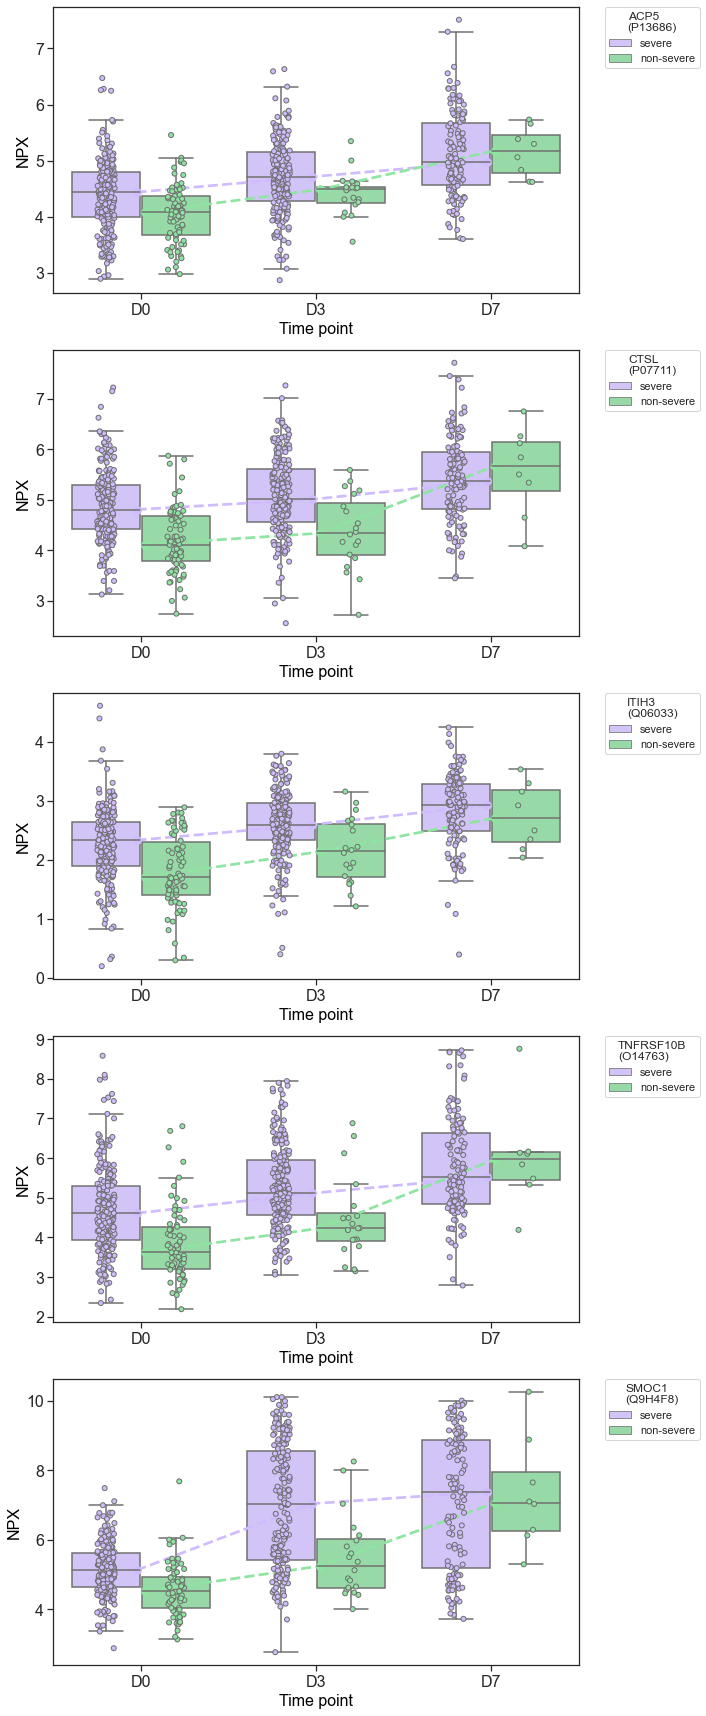

In [223]:
import seaborn as sns
from numpy import median
fig, axs = plt.subplots(nrows=5, figsize = (10, 24))
for i, protein in enumerate(top5):
    protein_info = protein_metadata.loc[protein, ['Assay', 'UniProt']].values.tolist()
    protein_label = protein_info[0] + '\n(' + protein_info[1] + ')'
    sns.boxplot(x="TimePoint", y=protein,
                hue="severity", palette=["m", "g"],
                data=NPX_metadata_new, showfliers = False, ax = axs[i])
    sns.stripplot(x="TimePoint", y=protein,
                hue="severity", split = True, jitter=True,
                data=NPX_metadata_new, linewidth=1, palette=["m", "g"], edgecolor='gray', ax = axs[i])
    sns.pointplot(x="TimePoint", y=protein,
            hue="severity", split = True, jitter=True, dodge = True,
            data=NPX_metadata_new,estimator=median, linewidth=1, palette=["m", "g"], 
              plot_kws=dict(alpha=1), linestyles=["--", "--"], ci = 0, ax = axs[i])
#     sns.lineplot(x="TimePoint", y=protein,
#                 hue="severity",
#                 data=NPX_metadata_new,estimator=median, linewidth=1, palette=["m", "g"], markers=True,
#                     ax = axs[i])
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                  title = protein_label)
    axs[i].set_ylabel('NPX', fontsize=16, c = 'black')
    axs[i].set_xlabel('Time point', fontsize=16, c = 'black')
    axs[i].tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()
plt.show()

In [32]:
# results = []
# for protein in progr_proteins:
#     try:
#         res_severity = pg.pairwise_gameshowell(data=NPX_metadata_new, dv=protein,
#                             between='severity')
#         res_timepoint = pg.pairwise_gameshowell(data=NPX_metadata_new, dv=protein,
#                             between='TimePoint')
#         if (res_severity['pval'] < 0.05).all() & (res_timepoint['pval'] < 0.05).all():
#             results.append(protein)
#     except KeyError:
#         print('Error for protein {}'.format(protein))

In [33]:
len(results)

115

In [36]:
df_boxplots = NPX_metadata_new[["TimePoint", 'severity'] + results]
df_boxplots.head()

TimePoint  severity  OID20106  OID20401  OID20395  OID20359  OID20314  \
0          1         1    1.2732    6.1259    4.4675    2.4248    3.6055   
1          2         1    2.0977    6.2998    4.2346    2.3694    4.1034   
2          1         1    1.4211    6.4573    5.2040    3.2114    3.2850   
3          2         1    1.1949    6.6597    5.5643    2.8863    3.7694   
4          1         1    1.9144    7.5803    7.7113    2.7929    4.3258   

   OID20203  OID20307  OID20222  ...  OID21422  OID21214  OID21441  OID21250  \
0    1.8381    1.8453    5.5052  ...    2.2298    0.2397    2.0596    2.4890   
1    1.7268    1.9340    5.7288  ...    2.4342    0.7543    1.9661    2.8424   
2    0.6945    1.0194    5.3515  ...    2.2073   -0.4130    1.5714    2.8236   
3    1.1682    0.8101    4.9374  ...    2.2049   -0.2440    1.1902    4.3285   
4    1.8197    1.1646    6.6589  ...    3.8339    1.3536    2.6115    7.5268   

   OID21434  OID21380  OID21371  OID21528  OID21482  OID21171  
0    4.0671    3.6861    1.5271    5.5782    1.6896    0.8579  
1    4.6363    3.2954    2.1797    6.1060    1.7036   -0.0138  
2    5.9000    3.5102    1.7938    6.1147    1.1985    0.1039  
3    5.0539    3.5289    1.2507    5.7463    1.2585    0.5838  
4    5.9405    5.3703    2.6738    6.4539    2.6966    1.5354  

[5 rows x 117 columns]

In [41]:
severe_df_boxplots = df_boxplots[df_boxplots['severity'] == 1]
severe_boxplot = pd.DataFrame()
for protein in results:
    a = severe_df_boxplots.groupby(by = 'TimePoint').apply(lambda x: x[protein].median())
    severe_boxplot = severe_boxplot.append([[protein, a.std().round(3)]], ignore_index = True)
severe_boxplot.columns = ['protein', 'median_std']
severe_boxplot = severe_boxplot.sort_values(by = 'median_std', ascending = False).reset_index(drop = True)
severe_boxplot

In [54]:
severe_boxplot = severe_boxplot.sort_values(by = 'median_std', ascending = False).reset_index(drop = True)
severe_boxplot

protein  median_std
0    OID20169       1.361
1    OID20656       0.823
2    OID20672       0.802
3    OID21250       0.762
4    OID20697       0.726
..        ...         ...
110  OID20726       0.134
111  OID20307       0.133
112  OID21171       0.129
113  OID21495       0.113
114  OID21528       0.060

[115 rows x 2 columns]

In [55]:
non_severe_df_boxplots = df_boxplots[df_boxplots['severity'] == 0]
non_severe_boxplot = pd.DataFrame()
for protein in results:
    a = non_severe_df_boxplots.groupby(by = 'TimePoint').apply(lambda x: x[protein].median())
    non_severe_boxplot = non_severe_boxplot.append([[protein, a.std().round(3)]], ignore_index = True)
non_severe_boxplot.columns = ['protein', 'median_std']
non_severe_boxplot = non_severe_boxplot.sort_values(by = 'median_std', ascending = False).reset_index(drop = True)
non_severe_boxplot

protein  median_std
0    OID21505       1.251
1    OID20981       1.219
2    OID20964       1.210
3    OID20656       1.137
4    OID21155       1.118
..        ...         ...
110  OID21528       0.066
111  OID20857       0.056
112  OID20439       0.053
113  OID20455       0.048
114  OID21250       0.038

[115 rows x 2 columns]

In [57]:
severe_boxplot['protein'].iloc[:10].values

array(['OID20169', 'OID20656', 'OID20672', 'OID21250', 'OID20697',
       'OID20214', 'OID21505', 'OID21380', 'OID21422', 'OID21282'],
      dtype=object)

In [58]:
non_severe_boxplot['protein'].iloc[:10].values

array(['OID21505', 'OID20981', 'OID20964', 'OID20656', 'OID21155',
       'OID21145', 'OID20203', 'OID20610', 'OID21482', 'OID21457'],
      dtype=object)

In [65]:
proteins_for_final_boxplot = np.intersect1d(severe_boxplot['protein'].iloc[:15].values, non_severe_boxplot['protein'].iloc[:15].values).tolist()

In [66]:
proteins_for_final_boxplot

['OID20169', 'OID20656', 'OID20697', 'OID21482', 'OID21505']

In [117]:
days_dict = {1 : 'D0', 2 : 'D3', 3 : 'D7'}
severity_dict = {1:'severe', 0:'non-severe'}
NPX_metadata_new = NPX_metadata_new.replace({'severity' : severity_dict,
                                            'TimePoint' : days_dict}).reset_index(drop = True)

In [149]:
NPX_metadata_new[NPX_metadata_new['severity'] == 'non-severe'].TimePoint.value_counts()

D0    74
D3    20
D7     8
Name: TimePoint, dtype: int64

In [105]:
protein_metadata = pd.read_excel('../O_link_parser/parser_stuff/data/Olink Filbin sep2.xlsx', sheet_name='Olink-Assay', engine='openpyxl').set_index('OlinkID')

In [156]:
(NPX_metadata_new[['TimePoint', 'severity'] + [protein]].groupby(by = ['TimePoint','severity']).median()).reset_index()

TimePoint    severity  OID20169
0        D0  non-severe   2.81845
1        D0      severe   3.52140
2        D3  non-severe   3.96390
3        D3      severe   4.77610
4        D7  non-severe   4.61695
5        D7      severe   6.24000

In [106]:
protein_metadata

Assay UniProt  MissingFreq     LOD            Panel  Panel_Version
OlinkID                                                                       
OID20049     NPPB  P16860         0.55  1.9691  CARDIOMETABOLIC              1
OID20050    TNNI3  P19429         0.76  1.7430  CARDIOMETABOLIC              1
OID20051   HNRNPK  P61978         0.76  1.0000  CARDIOMETABOLIC              1
OID20052    CEBPB  P17676         0.80  0.6993  CARDIOMETABOLIC              1
OID20053      VIM  P08670         0.86  1.9438  CARDIOMETABOLIC              1
...           ...     ...          ...     ...              ...            ...
OID21527     CD27  P26842         0.04  0.9550         ONCOLOGY              1
OID21528  CEACAM1  P13688         0.03  2.0655         ONCOLOGY              1
OID21529    FOLR1  P15328         0.03  1.1917         ONCOLOGY              1
OID21530    LYPD3  O95274         0.04  0.2949         ONCOLOGY              1
OID21531      MIA  Q16674         0.04  0.2318         ONCOLOGY              1

[1429 rows x 6 columns]

c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)
c:\users\user94\desktop\bg\covid\analysis\lib\site-packages\seaborn\categorical.py:2805: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


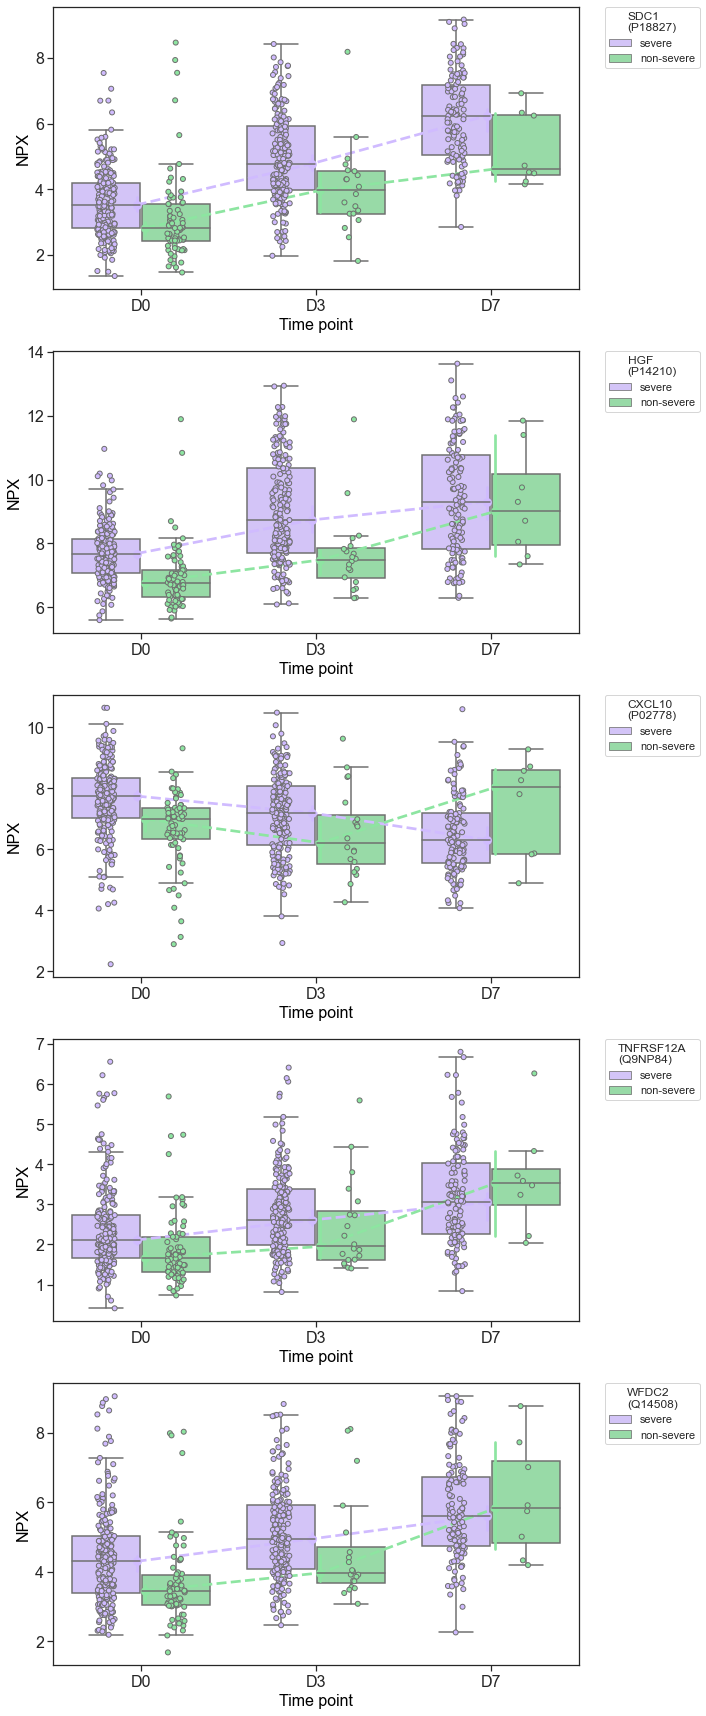

In [166]:
import seaborn as sns
from numpy import median
fig, axs = plt.subplots(nrows=5, figsize = (10, 24))
for i, protein in enumerate(proteins_for_final_boxplot):
    protein_info = protein_metadata.loc[protein, ['Assay', 'UniProt']].values.tolist()
    protein_label = protein_info[0] + '\n(' + protein_info[1] + ')'
    sns.boxplot(x="TimePoint", y=protein,
                hue="severity", palette=["m", "g"],
                data=NPX_metadata_new, showfliers = False, ax = axs[i])
    sns.stripplot(x="TimePoint", y=protein,
                hue="severity", split = True, jitter=True,
                data=NPX_metadata_new, linewidth=1, palette=["m", "g"], edgecolor='gray', ax = axs[i])
    sns.pointplot(x="TimePoint", y=protein,
                hue="severity", split = True, jitter=True, dodge = True,
                data=NPX_metadata_new,estimator=median, linewidth=1, palette=["m", "g"], 
                  plot_kws=dict(alpha=1), linestyles=["--", "--"], ax = axs[i])
    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                  title = protein_label)
    axs[i].set_ylabel('NPX', fontsize=16, c = 'black')
    axs[i].set_xlabel('Time point', fontsize=16, c = 'black')
    axs[i].tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()
plt.show()
# fig.savefig('boxplots_var2.png', dpi = 300)

In [69]:
tips

total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]

<AxesSubplot:xlabel='day', ylabel='total_bill'>

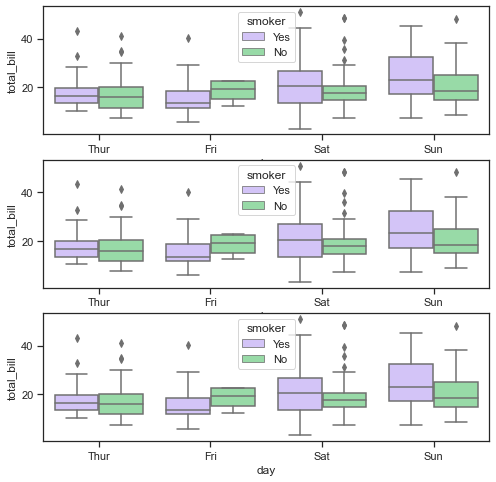

In [ ]:
# import matplotlib.pyplot as plt
# fig, axs = plt.subplots(10, 5, figsize = (20, 20))
# i = 0
# for protein, coord in results.items():
#     if coord:
#         _x = coord[0]
#         _y = coord[1]
#         row = i//5
#         col = i%5
#         axs[row, col].scatter(_x, _y, s = 10, color = 'g', alpha = 1, label = 'lin_part')
#         table = std_result[std_result['Protein_name'] == protein]
#         table = table[table['Sample'].str.contains('[Std][\d]{1}[\_]{1}[\d]{2}[\.]', regex = True)]
# #         table = table[table['Sample'].str.contains('[Std][\d]{1}[\_]{1}[2][5]', regex = True)]
# #         table = table[table['Sample'].str.contains('[Std][\d]{1}[\_]{1}[5][0]', regex = True)]
# #         table['y'] = table['y'] - table.iloc[7, 3]
#         table = table.iloc[:7]
#         axs[row, col].scatter(table.loc[:, 'conc'], table.loc[:, 'y'], color = 'b', s = 10, alpha = 0.5,
#                              label = 'std')
#         i += 1
#         axs[row, col].set_xlabel('Expected_conc')
#         axs[row, col].set_ylabel('Signal')
#         axs[row, col].set_xscale('log')
#         axs[row, col].patch.set_facecolor = 'white'
#         axs[row, col].legend(loc = 'upper center', title = protein, fontsize = 'xx-small',
#                         title_fontsize = 'xx-small')
# fig.patch.set_facecolor('white')
# fig.tight_layout()
# plt.show()
# name = 'log_sigma_' + str(sigma) + 'del_12_5' + 'signal0'+ '.png'
# fig.savefig(name, dpi = 300 , bbox_inches = 'tight')

In [ ]:
###################################################################################################

In [96]:
# import statsmodels
# from statsmodels.stats.diagnostic import het_white
# from statsmodels.stats.stattools import durbin_watson
# from scipy import stats
# covariates = ['COVID', 'Age_cat', 'HEART', 'LUNG', 'KIDNEY', 'DIABETES', 'HTN', 'IMMUNO']
# NPX_metadata.rename(columns = {'Age cat' : 'Age_cat'}, inplace = True)
# NPX_metadata = NPX_metadata[NPX_metadata['TimePoint'] == 'D0']
# i = 0
# for protein in proteins:
# #     print(protein)
#     model = ols(protein + '~' + '+'.join(covariates), data = NPX_metadata.rename(columns = {'Age cat' :
#                                                                                            'Age_cat'})).fit()
# #     print(model.summary())
#     aov_table = sm.stats.anova_lm(model).iloc[:-1]
#     aov_table['Adjusted_pval'] = statsmodels.stats.multitest.fdrcorrection(aov_table.iloc[:, -1].values)[1]
# #     print(model.f_pvalue)
# #     print(aov_table['PR(>F)'].loc['COVID'])
#     if (model.f_pvalue >= 0.05) & (aov_table['Adjusted_pval'].loc['COVID'] < 0.05):
#         print('protein: {} \nmodel.f_pvalue: {} \nAdjusted_pval: {}'.format(protein, model.f_pvalue,
#                                                                            aov_table['Adjusted_pval'].loc['COVID']))
#     white_test = het_white(model.resid,  model.model.exog)
#     shapiro_test = stats.shapiro(model.resid)
# #     print(durbin_watson(model.resid))
# #     if (white_test[1] < 0.05) & (shapiro_test[1] < 0.05) & (1.5 < durbin_watson(model.resid) < 2.5):
# #         pass
# #         print('protein: {} \nheteroskedasticity p-value: {} \nresiduals normality: {} \nindependence: {} \nstatus: {}'.format(
# #         protein, white_test[1], shapiro_test[1], durbin_watson(model.resid), 'YES'))
# #     else:
# #         print('protein: {} \nheteroskedasticity p-value: {} \nresiduals normality: {} \nstatus: {}'.format(
# #         protein, white_test[1], shapiro_test[1], 'NO'))
# # #         print(type(model.params))
# #         i+=1
# #         break
# #     coeff = model.params
# #     a = (NPX_metadata[covariates] * coeff[1:]).sum(axis = 1)

In [20]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
import seaborn as sns

plt.style.use('ggplot')

In [ ]:
import numpy as np
normality_test = []
for protein in ss_proteins:
    subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
    covid_p = subset[subset['COVID'] == 1].loc[:, protein]
    covid_n = subset[subset['COVID'] == 0].loc[:, protein])
    booted_data = get_bootstrap(covid_p, covid_n)
#     mannwhitneyu(covid_p.value, covid_n.value)[1]
    results = results.append([[protein, booted_data['p_value'], mannwhitneyu(covid_p.values, covid_n.values)[1]]],
                            ignore_index = True)
#     break
    #     print('p_value from bootstraping: {}'.format(booted_data['p_value']))
#     break
#     values = np.log(subset[protein].values.tolist())
#     if stats.shapiro(values)[1] < 0.05:
#         normality_test.append(protein)

In [ ]:
results.columns = ['protein', 'bootstrap', 'mann-whitney']

In [92]:
for i, protein in enumerate(ss_proteins):
    subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
    covid_p = subset[subset['COVID'] == 1].loc[:, protein]
    covid_n = subset[subset['COVID'] == 0].loc[:, protein]
    results.iloc[i, -1] = ttest_ind(covid_p, covid_n)[1]

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\user94\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [94]:
results['adj_t_test'] = statsmodels.stats.multitest.fdrcorrection(results.loc[:, 't_test'])[1]

<ipython-input-94-9855774143c4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['adj_t_test'] = statsmodels.stats.multitest.fdrcorrection(results.loc[:, 't_test'])[1]


In [106]:
results[results['adj_t_test'] >= 0.05]

protein  bootstrap  mann-whitney  adj_mann-whitney  adj_bootstrap  \
94   OID20242   0.006045      0.039313          0.039773       0.006045   
200  OID20764   0.005882      0.055891          0.056380       0.005891   

        t_test adj_t_test  
94    0.064734   0.064734  
200  0.0582151  0.0582993

C:\Users\user94\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user94\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

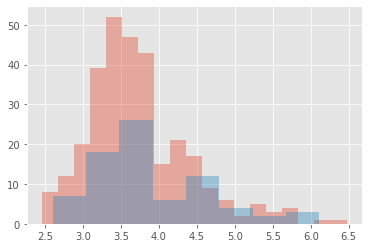

In [108]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# # Plot
# fig, ax = plt.subplots(figsize = (10, 10))
# for i, protein in enumerate(diff_protein):
#     ax.scatter([i]*NPX_metadata.shape[0], NPX_metadata[protein].values, label=protein)
# ax.legend()

# plt.show()
# fig, ax = plt.subplots(figsize = (8, 8))
# for i, protein in enumerate(results[results['adj_mann-whitney'] >= 0.05].loc[:, 'protein'].values):
#     row = i//2
#     col = i%2
protein = 'OID20242'
subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
sns.distplot(subset[subset['COVID'] == 1].loc[:, protein].values, kde=False,
            label = 'covid+')
sns.distplot(subset[subset['COVID'] == 0].loc[:, protein].values, kde=False,
            label = 'covid-')
# axs[row, col].legend(loc = 'upper right', title = protein)
# fig, axs = plt.subplots(4, 2, figsize = (8, 8))
# for i, protein in enumerate(results[results['adj_mann-whitney'] >= 0.05].loc[:, 'protein'].values):
#     row = i//2
#     col = i%2
#     subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
#     sns.distplot(subset[subset['COVID'] == 1].loc[:, protein].values, kde=False, ax = axs[row, col],
#                 label = 'covid+')
#     sns.distplot(subset[subset['COVID'] == 0].loc[:, protein].values, kde=False, ax = axs[row, col],
#                 label = 'covid-')
#     axs[row, col].legend(loc = 'upper right', title = protein)
#     axs[row, col].patch.set_facecolor = 'white'
# fig.patch.set_facecolor('white')
# fig.tight_layout()
# plt.show()    
# fig.savefig('example_new_1_white.png', dpi = 300 , bbox_inches = 'tight')

In [74]:
results['adj_mann-whitney'] = statsmodels.stats.multitest.fdrcorrection(results.loc[:, 'mann-whitney'])[1]
results['adj_bootstrap'] = statsmodels.stats.multitest.fdrcorrection(results.loc[:, 'bootstrap'])[1]

ValueError: shape mismatch: value array of shape (692,692)  could not be broadcast to indexing result of shape (692,1,692)

In [29]:
# t_test = []
# for i, value in enumerate(statsmodels.stats.multitest.fdrcorrection(normality_test)[1]):
#     subset = NPX_metadata[~pd.isna(NPX_metadata[ss_proteins[i]])]
#     covid_ p = subset[subset['COVID'] == 1].loc[:, protein].values
#     if value < 0.05:
#         t_test.append(scipy.stats.ttest_ind(covid_ p)[1])
        

OID20187 0.25205776327384444
OID20180 0.5247444744840462
OID20148 0.16730378333366278
OID20196 0.10019904571625353
OID20341 0.34061114164553635
OID20113 0.21388990743024214
OID20302 0.06049476489656811
OID20214 0.17146485376646586
OID20142 0.12126080534840358
OID20274 0.09690566235057403
OID20334 0.1632471015750456
OID20234 0.10577336569840108
OID20412 0.4218907447826211
OID20170 0.6656328833591171
OID20193 0.22839036195174509
OID20362 0.21051611577657828
OID20268 0.08247311783503301
OID20342 0.7756668159434962
OID20652 0.5780480835756366
OID20781 0.6407544689681135
OID20623 0.5305153825703789
OID20726 0.33290634570377214
OID20602 0.05484741121855987
OID20719 0.16544786380527596
OID20780 0.33151965461560146
OID20599 0.33250129844676896
OID20611 0.16116013029757517
OID20581 0.7026575941238961
OID20694 0.08809994209494436
OID20731 0.6346984304640649
OID20741 0.7257262683818361
OID20947 0.1837018859512306
OID20954 0.4770968470249907
OID20937 0.11103893397233537
OID20932 0.4007998877728479

In [130]:
proteins

['OID20321',
 'OID20206',
 'OID20195',
 'OID20094',
 'OID20216',
 'OID20106',
 'OID20324',
 'OID20299',
 'OID20381',
 'OID20187',
 'OID20202',
 'OID20180',
 'OID20099',
 'OID20281',
 'OID20385',
 'OID20097',
 'OID20300',
 'OID20383',
 'OID20396',
 'OID20159',
 'OID20120',
 'OID20154',
 'OID20287',
 'OID20401',
 'OID20310',
 'OID20265',
 'OID20148',
 'OID20279',
 'OID20071',
 'OID20069',
 'OID20179',
 'OID20286',
 'OID20273',
 'OID20133',
 'OID20395',
 'OID20157',
 'OID20325',
 'OID20196',
 'OID20341',
 'OID20407',
 'OID20104',
 'OID20096',
 'OID20261',
 'OID20138',
 'OID20175',
 'OID20144',
 'OID20260',
 'OID20254',
 'OID20113',
 'OID20302',
 'OID20344',
 'OID20360',
 'OID20377',
 'OID20143',
 'OID20122',
 'OID20167',
 'OID20408',
 'OID20359',
 'OID20410',
 'OID20109',
 'OID20290',
 'OID20257',
 'OID20107',
 'OID20312',
 'OID20314',
 'OID20386',
 'OID20292',
 'OID20350',
 'OID20241',
 'OID20358',
 'OID20266',
 'OID20413',
 'OID20203',
 'OID20220',
 'OID20171',
 'OID20100',
 'OID20050',

In [127]:
NPX_metadata.T

0       2       4       6       8       11      14      16   \
Patient ID       1       2       3       4       5       6       7       8   
TimePoint       D0      D0      D0      D0      D0      D0      D0      D0   
Public ID     1_D0    2_D0    3_D0    4_D0    5_D0    6_D0    7_D0    8_D0   
OID20321    4.1968  4.2154  4.5419   4.195  4.1539   4.382  4.2908  4.9513   
OID20206     5.531  7.7046  6.5252  3.1439   3.813  6.3042  5.7085  2.4306   
...            ...     ...     ...     ...     ...     ...     ...     ...   
LUNG             0       0       1       0       0       0       0       0   
KIDNEY           0       0       0       0       0       0       0       0   
DIABETES         0       0       0       0       1       0       1       1   
HTN              0       0       0       0       1       0       0       1   
IMMUNO           0       0       0       0       0       0       0       1   

               17      19   ...     761     763     765     768     771  \
Patient ID       9      10  ...     377     378     379     380     381   
TimePoint       D0      D0  ...      D0      D0      D0      D0      D0   
Public ID     9_D0   10_D0  ...  377_D0  378_D0  379_D0  380_D0  381_D0   
OID20321    4.5579  3.2289  ...  4.3189  3.8596  4.1533   4.798  4.2612   
OID20206    4.9414  5.4925  ...  4.0776  3.0311  4.6418  5.1391  6.4373   
...            ...     ...  ...     ...     ...     ...     ...     ...   
LUNG             1       0  ...       0       1       0       0       1   
KIDNEY           1       0  ...       0       0       0       0       0   
DIABETES         0       0  ...       1       1       0       0       1   
HTN              1       0  ...       1       1       0       0       1   
IMMUNO           0       0  ...       0       0       0       0       0   

               772     775     779     781     783  
Patient ID     382     383     384     385     386  
TimePoint       D0      D0      D0      D0      D0  
Public ID   382_D0  383_D0  384_D0  385_D0  386_D0  
OID20321    4.0827  4.4744  5.2782  4.4157  3.6408  
OID20206     3.028  3.7196  5.1374  7.0896  3.0779  
...            ...     ...     ...     ...     ...  
LUNG             0       0       0       0       1  
KIDNEY           0       1       0       0       0  
DIABETES         0       1       0       0       0  
HTN              0       1       1       0       1  
IMMUNO           0       0       0       0       0  

[1440 rows x 383 columns]

In [141]:
for i, row in NPX_metadata.T.loc[proteins].iterrows():
    if ~pd.isna(row).any():
        pass
    else:
        print(i)
#     print(~pd.isna(row).all())
#     print(i, row)
# #     if row.valu
#     break

OID20495
OID21263
OID21378


In [145]:
NPX_metadata[pd.isna(NPX_metadata['OID21378'])]

Patient ID TimePoint Public ID  OID20321  OID20206  OID20195  OID20094  \
120          57        D0     57_D0    4.3906    4.8942    1.9915    2.2038   
271         140        D0    140_D0    4.1859    6.1447    3.2589    5.6510   
294         151        D0    151_D0    4.0188    2.3796    5.3863    2.2628   
486         245        D0    245_D0    4.3509    3.0382    3.5265    2.5526   
752         372        D0    372_D0    4.1876    3.9612    3.3526    2.2060   

     OID20216  OID20106  OID20324  ...  OID21170  OID21469  COVID  Age_cat  \
120    3.2546    1.8924    6.1918  ...    1.1423    6.5552      1        3   
271    3.1147    2.2248    6.6178  ...    1.1074    5.6269      1        5   
294    3.3511    1.5650    6.2801  ...    0.0388    5.5662      0        1   
486    3.2493    1.7733    6.3634  ...    0.5785    4.0208      1        2   
752    1.9933    1.5480    6.4445  ...    0.3161    5.1812      1        1   

     HEART  LUNG  KIDNEY  DIABETES  HTN  IMMUNO  
120      0     0       0         0    1       0  
271      0     0       0         0    0       0  
294      0     0       0         0    0       0  
486      0     0       0         0    0       0  
752      0     0       0         0    0       0  

[5 rows x 1440 columns]

In [98]:
len(ss_proteins)

692

In [111]:
# from statsmodels.stats.multicomp import pairwise_tukeyhsd
# result_proteins = []
for protein in list(set(ss_proteins).difference(set(result_proteins))):
    subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
    print(subset.shape)
#     tukey = pairwise_tukeyhsd(endog = NPX_metadata[protein],
#                           groups = NPX_metadata['COVID'],
#                           alpha = 0.05)
#     if tukey.pvalues < 0.05:
#         result_proteins.append(protein)

(383, 1440)
(383, 1440)
(378, 1440)
(382, 1440)


In [18]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
result_proteins = []
for protein in ss_proteins:
#     subset = NPX_metadata
    subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
    tukey = pairwise_tukeyhsd(endog = subset[protein],
                          groups = subset['COVID'],
                          alpha = 0.05)
#     print(tukey)
#     break
    if tukey.pvalues < 0.05:
        result_proteins.append(protein)

In [120]:
import scikit_posthocs as sp
result_proteins = []
for protein in ss_proteins:
    subset = NPX_metadata[~pd.isna(NPX_metadata[protein])]
    covid_p = subset[subset['COVID'] == 1].loc[:, protein].values
    covid_n = subset[subset['COVID'] == 0].loc[:, protein].values
    data = [covid_p, covid_n]
    res = sp.posthoc_dunn(data, p_adjust = 'holm')
    if res[1][2] < 0.05:
        result_proteins.append(protein)
#     print(res[1][2])
#     break
#     if res.pvalue < 0.05:
#         result_proteins.append(protein)
#     tukey = pairwise_tukeyhsd(endog = subset[protein],
#                           groups = subset['COVID'],
#                           alpha = 0.05)
#     print(tukey)
#     break
#     if tukey.pvalues < 0.05:
#         result_proteins.append(protein)


In [19]:
len(result_proteins)

690

In [20]:
list(set(ss_proteins).difference(set(result_proteins)))

['OID20764', 'OID20242']

In [107]:
a = posthoc[posthoc['OlinkID'].isin(result_proteins)]
a[a['Threshold'] == 'Non-significant']

OlinkID   Assay contrast (COVID positive - COVID negative)  \
602   OID20911     IL6                        Positive - Negative   
603   OID20101     IL6                        Positive - Negative   
604   OID20166   GSTA1                        Positive - Negative   
605   OID21276     IL6                        Positive - Negative   
606   OID20563     IL6                        Positive - Negative   
...        ...     ...                                        ...   
1278  OID20339    CD59                        Positive - Negative   
1288  OID20731   TREM2                        Positive - Negative   
1297  OID20497    ENAH                        Positive - Negative   
1330  OID20388    TFPI                        Positive - Negative   
1407  OID20325  IGFBP2                        Positive - Negative   

      estimate (difference in expression given as COVID-positive minus COVID-negative)  \
602                                            0.538671                                  
603                                            0.537550                                  
604                                            0.516157                                  
605                                            0.496633                                  
606                                            0.475562                                  
...                                                 ...                                  
1278                                          -0.032832                                  
1288                                          -0.030615                                  
1297                                          -0.028752                                  
1330                                          -0.020718                                  
1407                                           0.003490                                  

      standard error  degrees of freedom   t.ratio   p.value  \
602         0.245628                 364  2.193038  0.028937   
603         0.243769                 364  2.205157  0.028068   
604         0.233069                 364  2.214612  0.027406   
605         0.241328                 364  2.057920  0.040309   
606         0.242993                 364  1.957104  0.051099   
...              ...                 ...       ...       ...   
1278        0.107489                 364 -0.305450  0.760198   
1288        0.105498                 364 -0.290198  0.771830   
1297        0.094456                 364 -0.304401  0.760997   
1330        0.065528                 364 -0.316165  0.752058   
1407        0.137495                 364  0.025384  0.979762   

      Adjusted_pval (after MHT)        Threshold  
602                    0.065017  Non-significant  
603                    0.063665  Non-significant  
604                    0.062460  Non-significant  
605                    0.084585  Non-significant  
606                    0.102846  Non-significant  
...                         ...              ...  
1278                   0.836166  Non-significant  
1288                   0.843306  Non-significant  
1297                   0.836166  Non-significant  
1330                   0.833740  Non-significant  
1407                   0.988757  Non-significant  

[160 rows x 10 columns]

In [103]:
posthoc[posthoc['OlinkID'].isin(list(set(ss_proteins).difference(set(result_proteins))))]

OlinkID  Assay contrast (COVID positive - COVID negative)  \
1235  OID20764  PLAUR                        Positive - Negative   
1410  OID20242  EPHB4                        Positive - Negative   

      estimate (difference in expression given as COVID-positive minus COVID-negative)  \
1235                                          -0.043101                                  
1410                                          -0.003014                                  

      standard error  degrees of freedom   t.ratio   p.value  \
1235        0.094095                 364 -0.458062  0.647181   
1410        0.081849                 364 -0.036828  0.970642   

      Adjusted_pval (after MHT)        Threshold  
1235                   0.754341  Non-significant  
1410                   0.983497  Non-significant

In [34]:
posthoc = pd.read_excel('1-s2.0-S2666379121001154-mmc4 (1).xlsx', sheet_name = 'posthoc')

In [43]:
posthoc_proteins = posthoc['OlinkID'].values.tolist()

In [49]:
posthoc_proteins = posthoc[posthoc['Threshold'] == 'Significant'].loc[:, 'OlinkID'].values.tolist()

In [51]:
diff_protein = list(set(result_proteins).difference(set(posthoc_proteins)))

In [55]:
anova = pd.read_excel('1-s2.0-S2666379121001154-mmc4 (1).xlsx', sheet_name = 'ANOVA')

In [66]:
anova_proteins = anova[(anova['term'] == 'COVID') & (anova['Adjusted_pval'] < 0.05)].loc[:, 'OlinkID'].values.tolist()

In [68]:
len(list(set(anova_proteins).difference(set(posthoc_proteins))))

0

In [141]:
# diff_protein = list(set(result_1).difference(set(result_2)))

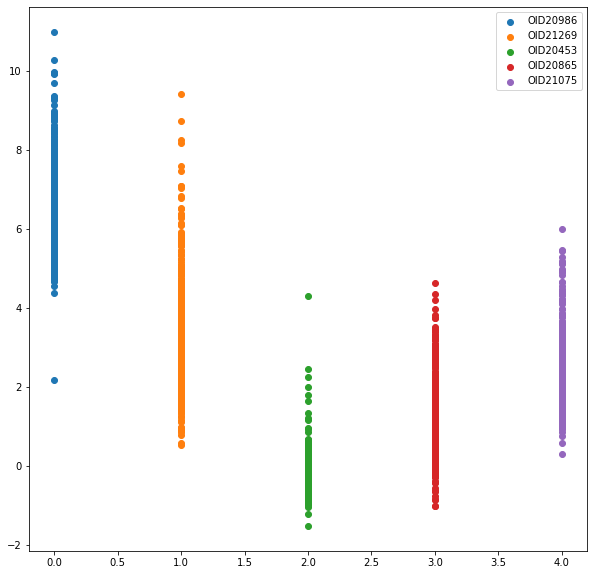

In [147]:
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# # Plot
# fig, ax = plt.subplots(figsize = (10, 10))
# for i, protein in enumerate(diff_protein):
#     ax.scatter([i]*NPX_metadata.shape[0], NPX_metadata[protein].values, label=protein)
# ax.legend()

# plt.show()


In [ ]:
##############################################################################################3

In [86]:
metadata = pd.read_excel('1-s2.0-S2666379121001154-mmc2 (1).xlsx', sheet_name = '1B-Subject-level metadata')

In [88]:
metadata = metadata.loc[:, ['Public ID', 'D0_draw', 'D3_draw', 'D7_draw', 'Acuity 0', 'Acuity 3', 'Acuity 7']]

In [89]:
metadata = metadata.fillna('-')

In [107]:
metadata.loc[383, 'D0_draw'] =1
metadata.loc[383, ['D3_draw', 'D7_draw']] = 0

In [108]:
metadata

Public ID D0_draw D3_draw D7_draw  Acuity 0  Acuity 3  Acuity 7
0            1     1.0     1.0     0.0         3         4         5
1            2     1.0     1.0     0.0         3         3         5
2            3     1.0     1.0     0.0         3         3         5
3            4     1.0     1.0     0.0         3         3         5
4            5     1.0     1.0     1.0         3         3         3
..         ...     ...     ...     ...       ...       ...       ...
379        382     1.0     1.0     1.0         4         2         2
380        383     1.0     0.0     1.0         2         2         2
381        384     1.0     0.0     1.0         3         3         3
382        385     1.0     1.0     0.0         3         4         5
383        386       1       0       0         3         5         5

[384 rows x 7 columns]

In [191]:
import collections
result_dict = dict()
result_table = pd.DataFrame()
for n_day in [0, 3, 7]:
    day, acuity = 'D{}_draw'.format(n_day), 'Acuity {}'.format(n_day)
    patients_metadata = metadata[metadata[day] == 1].loc[:, 'Public ID']
#     print(patients_metadata.shape[0])
    patients_NPX = NPX_values[(NPX_values['Patient ID'].isin(patients_metadata)) & (NPX_values['TimePoint'] == 'D'+str(n_day))].loc[:, 'Patient ID']
#     print(NPX_values[~((NPX_values['Patient ID'].isin(patients_metadata)))])
    patients = np.intersect1d(patients_metadata, patients_NPX)
    print(np.setdiff1d(patients_metadata, patients_NPX))
    sizes = metadata[metadata['Public ID'].isin(patients)].groupby(by = [acuity]).size()
    add = metadata[metadata['Public ID'].isin(patients)].loc[:,[acuity]].rename(
    columns = {acuity:'Acuity'})
    add['Day'] = day
    result_table = result_table.append(add,
                                      ignore_index = True)
#     print(sizes.sum())
    _dict = sizes.T.to_dict()
    for i in [1, 2, 3, 4, 5]:
        if not i in _dict:
            _dict[i] = 0
    _no = metadata[~metadata['Public ID'].isin(patients)].groupby(by = [acuity]).size()
    _add = metadata[~metadata['Public ID'].isin(patients)].loc[:,[acuity]].replace({2:6,3:6,4:6}).rename(
    columns = {acuity:'Acuity'})
    _add['Day'] = day
    print(_add)
    result_table = result_table.append(_add,
                                  ignore_index = True)
    nodraw = 0
#     print(_no.sum())
    for index in _no.index:
        if index in [1, 5]:
            print(_no.loc[index])
            _dict[index] = _dict[index] + _no.loc[index]
        else:
            nodraw += _no.loc[index]
    _dict[6] = nodraw
    result_dict[day] = collections.OrderedDict(sorted(_dict.items()))
#     print(_dict)        
#     yes = sizes.iloc[sizes.index.get_level_values(day) == 1]
#     yes.index = yes.index.get_level_values(acuity)
#     no = sizes.iloc[sizes.index.get_level_values(day) != 1]
#     print(no)
#     no.index = no.index.get_level_values(acuity)
#     print(no)
#     break
print(result_dict)

# In [2]: d = {2:3, 1:89, 4:5, 3:0}

# dict1 = collections.OrderedDict(sorted(dict.items()))
# print(od)

[180]
     Acuity      Day
179       6  D0_draw
[ 30 141 181 191 293 310 321]
     Acuity      Day
7         6  D3_draw
9         6  D3_draw
10        5  D3_draw
15        6  D3_draw
20        6  D3_draw
..      ...      ...
370       5  D3_draw
378       5  D3_draw
380       6  D3_draw
381       6  D3_draw
383       5  D3_draw

[174 rows x 2 columns]
11
77
[ 30  43  57  59  97 154 196 210 258 274 302 321 341]
     Acuity      Day
0         5  D7_draw
1         5  D7_draw
2         5  D7_draw
3         5  D7_draw
6         5  D7_draw
..      ...      ...
374       6  D7_draw
375       5  D7_draw
378       5  D7_draw
382       5  D7_draw
383       5  D7_draw

[253 rows x 2 columns]
23
164
{'D0_draw': OrderedDict([(1, 3), (2, 96), (3, 186), (4, 60), (5, 38), (6, 1)]), 'D3_draw': OrderedDict([(1, 11), (2, 76), (3, 90), (4, 43), (5, 78), (6, 86)]), 'D7_draw': OrderedDict([(1, 24), (2, 66), (3, 39), (4, 25), (5, 164), (6, 66)])}


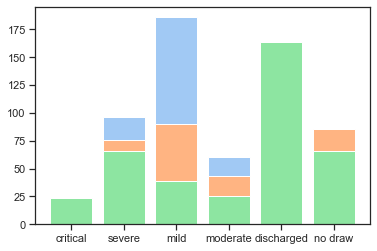

In [230]:
res = pd.DataFrame(result_dict)
for day in res.columns:
    plt.bar(['critical', 'severe', 'mild',
                                       'moderate', 'discharged', 'no draw'], res[day].values)

In [183]:
metadata[metadata['Public ID'].isin(patients)]

Public ID D0_draw D3_draw D7_draw  Acuity 0  Acuity 3  Acuity 7
4            5     1.0     1.0     1.0         3         3         3
5            6     1.0     1.0     1.0         3         3         3
11          12     1.0     1.0     1.0         2         2         2
13          14     1.0     1.0     1.0         3         2         2
14          15     1.0     1.0     1.0         2         2         2
..         ...     ...     ...     ...       ...       ...       ...
376        379     1.0     1.0     1.0         3         3         3
377        380     1.0     1.0     1.0         2         2         2
379        382     1.0     1.0     1.0         4         2         2
380        383     1.0     0.0     1.0         2         2         2
381        384     1.0     0.0     1.0         3         3         3

[131 rows x 7 columns]

In [ ]:
df_plot = df.groupby(['class', 'survived']).size().reset_index().pivot(columns='class', index='survived', values=0)

In [213]:
pd.DataFrame(result_dict).replace({
    1:'critical', 2:'severe', 3:'mild', 4:'moderate', 5:'discharged', 6:'no draw'
})

D0_draw  D3_draw  D7_draw
1      mild       11       24
2        96       76       66
3       186       90       39
4        60       43       25
5        38       78      164
6  critical       86       66

In [250]:
pd.DataFrame(result_dict).T

1   2    3   4    5   6
D0_draw   3  96  186  60   38   1
D3_draw  11  76   90  43   78  86
D7_draw  24  66   39  25  164  66

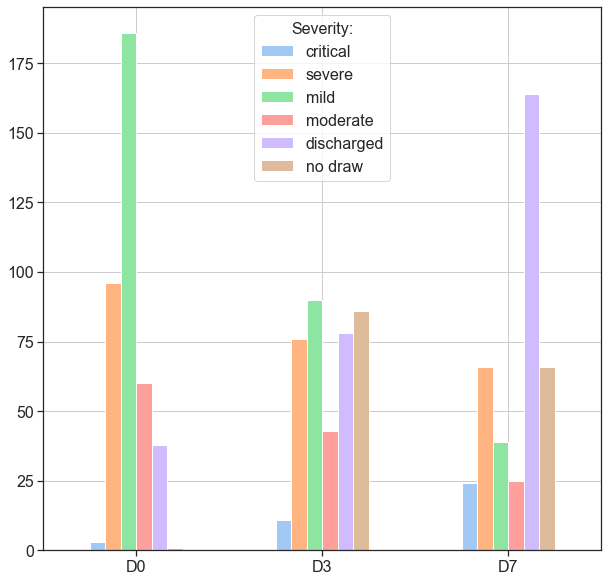

In [261]:
res = pd.DataFrame(result_dict)
res.index = ['critical', 'severe', 'mild',
                                       'moderate', 'discharged', 'no draw']
res.columns = ['D0', 'D3', 'D7']
ax = res.T.plot(kind='bar', figsize = (10, 10), grid = True, rot = 360)
ax.legend(title = 'Severity:', loc=9, fontsize=16, title_fontsize = 16)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.savefig('hist_1.png')
# plt.xticks(['critical', 'severe', 'mild',
#                                        'moderate', 'discharged', 'no draw'])
# plt.figure()
# plt.rcParams.update({'font.size': 22}) # must set in top

# ax1 = df_plot.plot(x='wind_direct',y=plot_columns,figsize=(30,18),linewidth=5,kind='line',legend=True, fontsize=16)
# ax1.legend(fo"ntsize=20)
# ax1.ylabel('kw',fontdict={'fontsize':24})
# ax2 = ax1.twinx()
# ax3 = df_plot.plot(x='wind_direct',y=counts_columns,figsize=(30,18),kind='bar',legend=True, ax=ax2, fontsize=16)
# ax3.set_title(title,pad=20, fontdict={'fontsize':24})
# ax.set_yticks(fontdict={'fontsize':12})
# ax3.legend(loc=1,fontsize=20);

In [180]:
penguins = sns.load_dataset("penguins")

In [182]:
sns.set_theme(style="ticks", palette="pastel")
fig, axs = plt.subplots(nrows=5, figsize = (10, 35))
for i, protein in enumerate(top5):
    protein_info = protein_metadata.loc[protein, ['Assay', 'UniProt']].values.tolist()
    protein_label = protein_info[0] + '\n(' + protein_info[1] + ')'
    sns.boxplot(x="TimePoint", y=protein,
                hue="severity", palette=["m", "g"],
                data=NPX_metadata_new, showfliers = False, ax = axs[i])
    sns.stripplot(x="TimePoint", y=protein,
                hue="severity", split = True, jitter=True,
                data=NPX_metadata_new, linewidth=1, palette=["m", "g"], edgecolor='gray', ax = axs[i])
    sns.pointplot(x="TimePoint", y=protein,
            hue="severity", split = True, jitter=True, dodge = True,
            data=NPX_metadata_new,estimator=median, linewidth=1, palette=["m", "g"], 
              plot_kws=dict(alpha=1), linestyles=["--", "--"], ci = 0, ax = axs[i])
    
    progress = {'D0_D3': [0, 1], 'D0_D7': [0, 2], 'D3_D7':[1, 2]}
    _y = []
    for comb, _x in progress.items():
        x1, x2 = _x
        y, h, col = NPX_metadata_new[(NPX_metadata_new['TimePoint'].isin(comb.split('_')))].loc[:,protein].max() + 0.5, 0.1, 'm'
        if _y:
            go = True
            for elem in _y:
                if abs(y - elem) < 0.5:
                    go = False
            if go==False:
                y = max(_y) + 0.5
        else:
            y = y + 0.3
        _y.append(y)        
        axs[i].plot([x1-0.2, x1-0.2, x2-0.2, x2-0.2], [y, y+h, y+h, y], lw=1.5, c=col)
        if results[(results['day_pair'] == comb) & (results['protein'] ==protein) &
                  (results['severity_A'] == 'severe') & (results['severity_B'] == 'severe')].empty:
            _text = 'ns'
        else:
            _text = '*'
        axs[i].text((x1+x2-0.4)*.5, y+h, _text, ha='center', va='bottom', color='k', fontsize=12)
    _y = []    
    for comb, _x in progress.items():
        x1, x2 = _x
        y, h, col = NPX_metadata_new[(NPX_metadata_new['TimePoint'].isin(comb.split('_')))].loc[:,protein].min() - 0.5, 0.1, 'g'
        if _y:
            go = True
            for elem in _y:
                if abs(y - elem) < 0.5:
                    go = False
            if go==False:
                y = min(_y) - 0.5
        _y.append(y) 
        axs[i].plot([x1+0.2, x1+0.2, x2+0.2, x2+0.2], [y, y-h, y-h, y], lw=1.5, c=col)
        if results[(results['day_pair'] == comb) & (results['protein'] ==protein) &
                  (results['severity_A'] == 'non-severe') & (results['severity_B'] == 'non-severe')].empty:
            _text = 'ns'
        else:
            _text = '*'
        axs[i].text((x1+x2+0.4)*.5, y-0.47, _text, ha='center', va='bottom', color='k', fontsize=12)
        
    for k, day in enumerate(['D0', 'D3', 'D7']): 
        x1, x2 = k, k   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
        y, h, col = NPX_metadata_new[(NPX_metadata_new['TimePoint'] == day)].loc[:,protein].max() + 0.2, 0.1, 'k'
        axs[i].plot([x1-0.2, x1-0.2, x2+0.2, x2+0.2], [y, y+h, y+h, y], lw=1, c=col)
        if results[(results['day_pair'] == '_'.join([day,day])) & (results['protein'] ==protein)].empty:
            _text = 'ns'
        else:
            _text = '*'
        axs[i].text((x1+x2)*.5, y+h, _text, ha='center', va='bottom', color='k', fontsize=12)    

    handles, labels = axs[i].get_legend_handles_labels()
    axs[i].legend(handles[0:2], labels[0:2], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                  title = protein_label)
    axs[i].set_ylabel('NPX', fontsize=16, c = 'black')
    axs[i].set_xlabel('Time point', fontsize=16, c = 'black')
    axs[i].tick_params(axis='both', which='major', labelsize=16)
fig.tight_layout()
plt.show()

species     island  bill_length_mm  bill_depth_mm  flipper_length_mm  \
0    Adelie  Torgersen            39.1           18.7              181.0   
1    Adelie  Torgersen            39.5           17.4              186.0   
2    Adelie  Torgersen            40.3           18.0              195.0   
3    Adelie  Torgersen             NaN            NaN                NaN   
4    Adelie  Torgersen            36.7           19.3              193.0   
..      ...        ...             ...            ...                ...   
339  Gentoo     Biscoe             NaN            NaN                NaN   
340  Gentoo     Biscoe            46.8           14.3              215.0   
341  Gentoo     Biscoe            50.4           15.7              222.0   
342  Gentoo     Biscoe            45.2           14.8              212.0   
343  Gentoo     Biscoe            49.9           16.1              213.0   

     body_mass_g     sex  
0         3750.0    Male  
1         3800.0  Female  
2         3250.0  Female  
3            NaN     NaN  
4         3450.0  Female  
..           ...     ...  
339          NaN     NaN  
340       4850.0  Female  
341       5750.0    Male  
342       5200.0  Female  
343       5400.0    Male  

[344 rows x 7 columns]

<AxesSubplot:xlabel='Acuity', ylabel='count'>

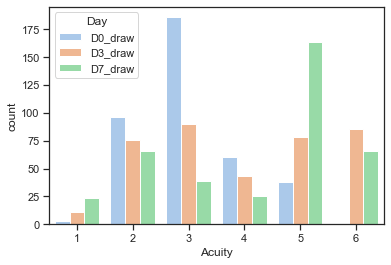

In [232]:
sns.countplot(data=result_table, x="Acuity", hue="Day")

In [172]:
result_dict['D0_draw'][1]

3

In [100]:
metadata.loc[179]

Public ID    180
D0_draw      1.0
D3_draw      0.0
D7_draw      0.0
Acuity 0       4
Acuity 3       5
Acuity 7       5
Name: 179, dtype: object

In [165]:
NPX_values[NPX_values['Patient ID'] == 141]

Patient ID TimePoint Public ID  OID20321  OID20206  OID20195  OID20094  \
274         141        D0    141_D0    4.9532    4.0695    6.5101     2.366   

     OID20216  OID20106  OID20324  ...  OID21321  OID21392  OID21431  \
274    2.4411    3.7132    5.3155  ...    0.5896    3.7029    5.9453   

     OID21526  OID21450  OID21518  OID21221  OID21261  OID21170  OID21469  
274    6.1091    6.1743    1.3261    0.0117    1.4807    0.9744    7.2704  

[1 rows x 1432 columns]

In [45]:
metadata.groupby(by = ['D3_draw', 'Acuity 3']).apply(lambda x: print(x))

    D0_draw D3_draw D7_draw  Acuity 0  Acuity 3  Acuity 7
45      1.0     0.0     0.0         1         1         1
55      1.0     0.0     0.0         1         1         1
74      1.0     0.0     0.0         3         1         1
166     1.0     0.0     0.0         3         1         1
200     1.0     0.0     0.0         2         1         1
270     1.0     0.0     0.0         2         1         1
312     1.0     0.0     0.0         3         1         1
315     1.0     0.0     0.0         1         1         1
326     1.0     0.0     0.0         2         1         1
362     1.0     0.0     0.0         3         1         1
    D0_draw D3_draw D7_draw  Acuity 0  Acuity 3  Acuity 7
15      1.0     0.0     0.0         2         2         3
52      1.0     0.0     1.0         2         2         2
71      1.0     0.0     0.0         2         2         4
85      1.0     0.0     0.0         2         2         2
96      1.0     0.0     1.0         3         2         2
110     1.0   

Empty DataFrame
Columns: []
Index: []

In [83]:
metadata.groupby(by = ['D0_draw', 'Acuity 0']).size()

D0_draw  Acuity 0
1.0      1             3
         2            96
         3           185
         4            61
         5            38
-        3             1
dtype: int64

In [ ]:
def counter(subset):
    

In [58]:
NPX_values[NPX_values['Patient ID'] == 0]

Empty DataFrame
Columns: [Patient ID, TimePoint, Public ID, OID20321, OID20206, OID20195, OID20094, OID20216, OID20106, OID20324, OID20299, OID20381, OID20187, OID20202, OID20180, OID20099, OID20281, OID20385, OID20097, OID20300, OID20383, OID20396, OID20159, OID20120, OID20154, OID20287, OID20401, OID20310, OID20265, OID20148, OID20279, OID20071, OID20069, OID20179, OID20286, OID20273, OID20133, OID20395, OID20157, OID20325, OID20196, OID20341, OID20407, OID20104, OID20096, OID20261, OID20138, OID20175, OID20144, OID20260, OID20254, OID20113, OID20302, OID20344, OID20360, OID20377, OID20143, OID20122, OID20167, OID20408, OID20359, OID20410, OID20109, OID20290, OID20257, OID20107, OID20312, OID20314, OID20386, OID20292, OID20350, OID20241, OID20358, OID20266, OID20413, OID20203, OID20220, OID20171, OID20100, OID20050, OID20101, OID20361, OID20077, OID20379, OID20293, OID20194, OID20387, OID20210, OID20389, OID20307, OID20212, OID20217, OID20372, OID20205, OID20289, OID20199, OID20340, OID20231, OID20211, OID20208, ...]
Index: []

[0 rows x 1432 columns]

In [64]:
NPX_values.groupby(by = ['TimePoint']).size()

TimePoint
D0      383
D3      218
D3.1      1
D7      135
D7.1      3
D7.2      1
DE       41
DE.1      1
DE.2      1
dtype: int64